# Course work

## Task
Marketing campaigns are an essential part of the business. This is also true for banking services. Meanwhile, the estimation of marketing campaign performance and prediction of performance is a challenging task. Based on historical data related to direct marketing campaigns of a Portuguese banking institution try to predict subscription for deposit

Metrics:
As for subscription prediction, we can't prefer precision or recall and the task is about binary classification, ROC AUC score will be used.
*   ROC AUC score maximization
*   ROC AUC score >= 80%

Dataset for research available [here](https://archive.ics.uci.edu/dataset/222/bank+marketing)

## Product questions
We need to build a prediction model, depending on the usage of this model we could differently use our train data. So we need to understand:
- Will the model be trained and used once before the campaign started to predict results? In this case, we can't train our model with data about the current marketing campaign
- Will the model be used continuously during the marketing campaign for every single user and our prediction about success will change with any new data incoming (like new contact information during the current campaign)? In this case, the whole dataset is applicable. But at what point (monitoring metrics) we should retrain our model as we have more historical data
- Marketing campaigns can have specifics like end and start date, do we have a dataset that covers the whole timeline of the previous campaign?

To find out answers we need to keep in mind the workflow of the user, who will use the model.

I will go with the assumption that the model will be used continuously during one campaign and re-run predictions for specific user on every data update. After the final result (answer yes or no) model metrics will be recalculated and if it is below baseline retrain happen.  

## EDA:

In [29]:
import warnings
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib
plt = matplotlib.pyplot

warnings.filterwarnings('ignore')

sns.set_theme()

print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"missingno: {msno.__version__}")
print(f"numpy: {np.__version__}")

pandas: 1.5.3
seaborn: 0.12.2
missingno: 0.5.2
numpy: 1.22.4


In [4]:
url = 'https://raw.githubusercontent.com/dmytrovelychko/rd_ds_python/main/datasets/bank-additional-full.csv'
df = pd.read_csv(url, sep=";")
print(f"shape: {df.shape}")
df[:100]

shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45,services,married,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
96,42,management,married,university.degree,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
97,53,admin.,divorced,university.degree,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
98,37,technician,single,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Text(0.5, 0, 'y (subscription result)')

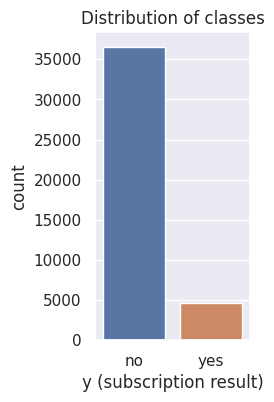

In [30]:
plt.figure(figsize=(2,4))
sns.countplot(x=df['y'])
plt.title('Distribution of classes')
plt.xlabel('y (subscription result)')

Highly imbalanced classes of taget feature

### Numerical features


In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### age

Text(0.5, 1.0, 'Distribution of users by age')

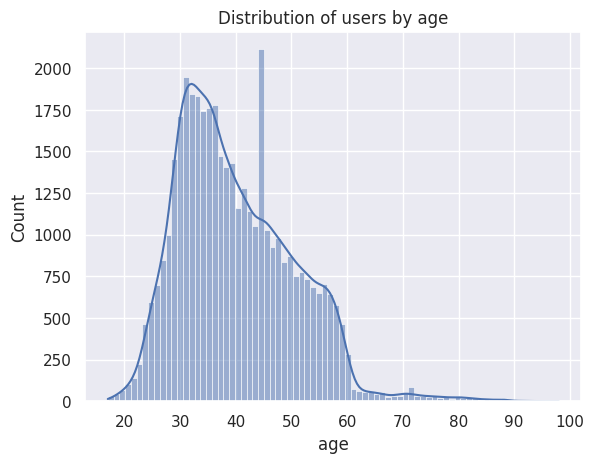

In [32]:
sns.histplot(df['age'], bins=len(df['age'].unique()), kde=True)
plt.title('Distribution of users by age')

- most if the users 25<age<60

Text(0.5, 0, 'age')

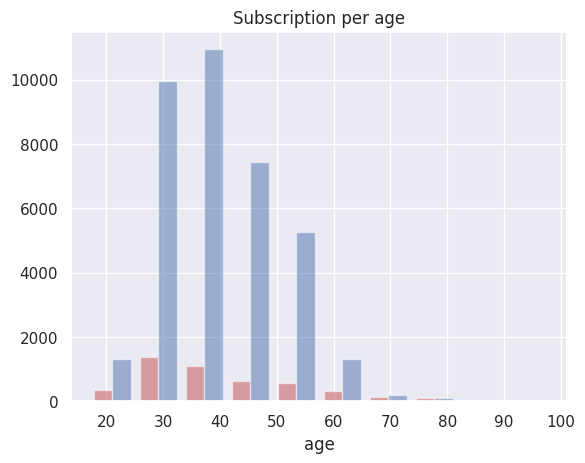

In [33]:
plt.hist([df[df['y'] == 'yes']['age'], df[df['y'] == 'no']['age']], color=['r','b'], alpha=0.5)
plt.title('Subscription per age')
plt.xlabel('age')

- highest subscription rate for near age = 30
- more younger more tend to subscribe for age >= 25

Text(0.5, 1.0, 'Outliers for age')

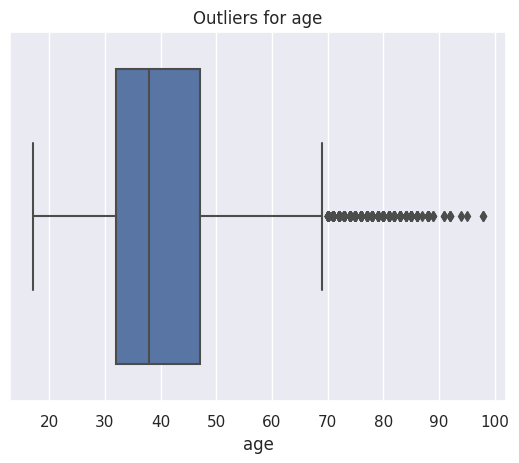

In [41]:
sns.boxplot(data=df, x="age")
plt.title('Outliers for age')

Text(0, 0.5, 'subscription')

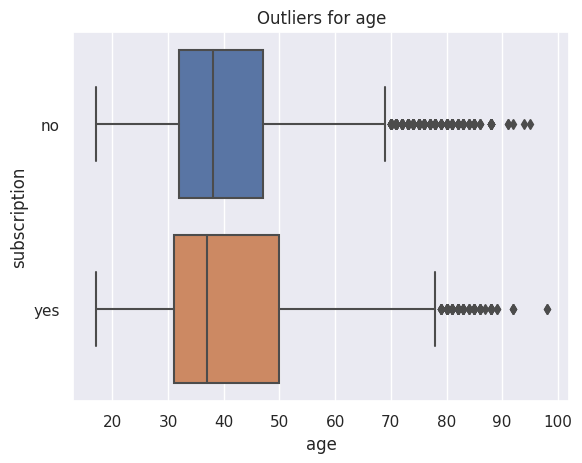

In [36]:
sns.boxplot(data=df, x="age", y="y")
plt.title('Outliers for age')
plt.ylabel('subscription')

- outliers candidates are with age>=70

#### balance

#### day

#### duration

#### campaign

#### pdays

#### previous

In [ ]:
df = df.drop_duplicates()
df.shape

(44400, 13)

In [1]:
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

NameError: ignored

there is notable correlation between **pdays**: number of days that passed by after the client was last contacted from a previous
and **previous**: number of contacts performed before this campaign and for this client

age            Axes(0.125,0.11;0.168478x0.77)
balance     Axes(0.327174,0.11;0.168478x0.77)
pdays       Axes(0.529348,0.11;0.168478x0.77)
previous    Axes(0.731522,0.11;0.168478x0.77)
dtype: object

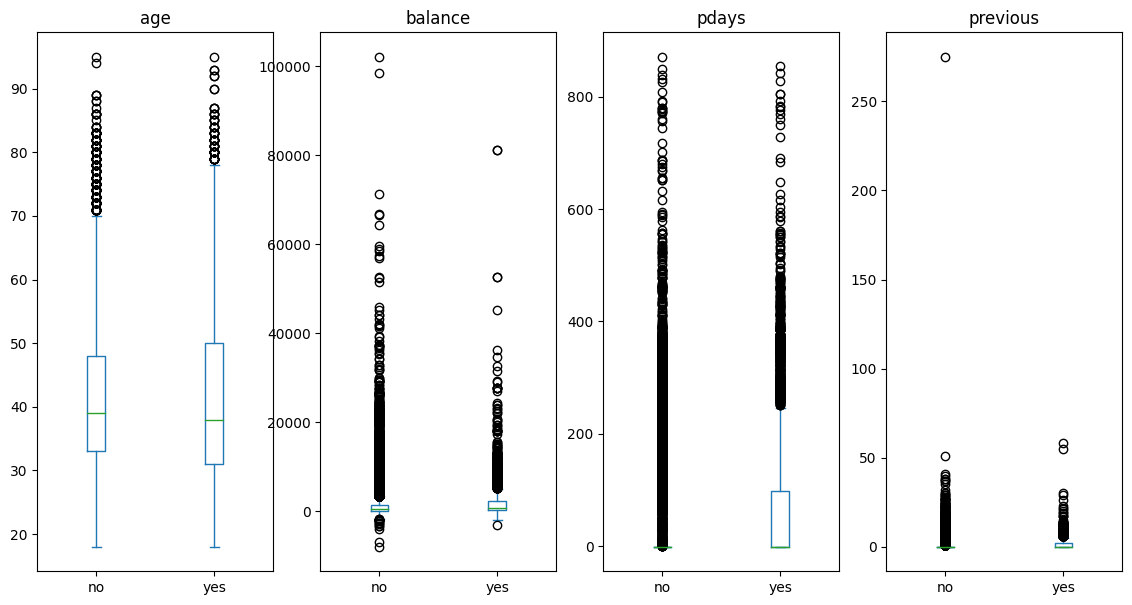

In [ ]:
df.plot.box(by="y", figsize=(14,7))

We have outliers in all numerical features, let's look at the most extreme values

In [ ]:
df[df["age"] > 90]

,age,job,marital,education,default,balance,housing,loan,contact,pdays,previous,poutcome,y
31233,94,retired,divorced,secondary,no,1234,no,no,cellular,-1,0,unknown,no
33699,95,retired,divorced,primary,no,2282,no,no,telephone,-1,0,unknown,yes
41663,95,retired,married,secondary,no,0,no,no,telephone,-1,0,unknown,no
41934,92,retired,married,unknown,no,775,no,no,cellular,-1,0,unknown,yes
42727,92,retired,married,unknown,no,775,no,no,cellular,96,3,success,yes
44262,93,retired,married,unknown,no,775,no,no,cellular,177,7,success,yes
44420,93,retired,married,unknown,no,775,no,no,cellular,13,9,success,yes


In [ ]:
df[df["balance"] > 80000]

,age,job,marital,education,default,balance,housing,loan,contact,pdays,previous,poutcome,y
26227,59,management,married,tertiary,no,98417,no,no,telephone,-1,0,unknown,no
39989,51,management,single,tertiary,no,102127,no,no,cellular,-1,0,unknown,no
42558,84,retired,married,secondary,no,81204,no,no,telephone,313,2,other,yes
43393,84,retired,married,secondary,no,81204,no,no,telephone,94,3,success,yes


seems reasonable, data looks valid

In [ ]:
df[df["previous"] > 50]

,age,job,marital,education,default,balance,housing,loan,contact,pdays,previous,poutcome,y
28886,31,management,single,tertiary,no,358,yes,no,cellular,256,51,failure,no
29182,40,management,married,tertiary,no,543,yes,no,cellular,262,275,other,no
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,353,58,other,yes
44089,37,technician,married,secondary,no,432,yes,no,cellular,776,55,failure,yes


previous    Axes(0.125,0.11;0.775x0.77)
dtype: object

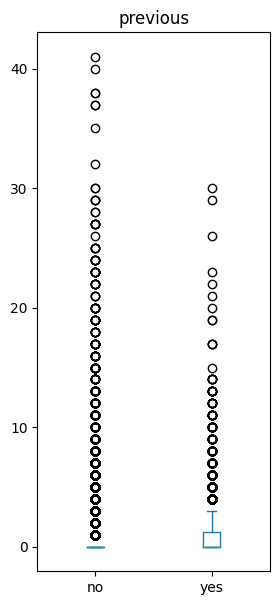

In [ ]:
df[df["previous"] <= 50][["previous", "y"]].plot.box(by="y", figsize=(3,7))

Don't see any reasons to tackle outliers of age, balance and previous as invalid data or edge cases. But amount of them is very small, so will skip for now any treatment, but if choosen ml algorithm will be sensitive to outliers or can't reach metrics goal will try winsorizing.

If previous == 0, pdays == -1. Let's check if we have invalid records:

In [ ]:
df[df["previous"] == 0][df["pdays"] != -1].shape

(0, 13)

In [ ]:
df[df["previous"] != 0][df["pdays"] == -1].shape

(0, 13)

all good

### Categorical features

In [ ]:
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome", "y"]

In [ ]:
for col in cat_cols:
  print(df[col].value_counts(), '\n')

blue-collar      9570
management       9153
technician       7426
admin.           5111
services         4102
retired          2238
self-employed    1573
entrepreneur     1479
unemployed       1297
housemaid        1228
student           936
unknown           287
Name: job, dtype: int64 

married     26655
single      12585
divorced     5160
Name: marital, dtype: int64 

secondary    22831
tertiary     12961
primary       6757
unknown       1851
Name: education, dtype: int64 

no     43588
yes      812
Name: default, dtype: int64 

yes    24796
no     19604
Name: housing, dtype: int64 

no     37188
yes     7212
Name: loan, dtype: int64 

cellular     28655
unknown      12849
telephone     2896
Name: contact, dtype: int64 

unknown    36148
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64 

no     39118
yes     5282
Name: y, dtype: int64 



Our target feature is pretty unbalanced, need to take this in acount during test/train split. Target feature is categorical, model should solve classification task.

Besides that there are plenty records with unknown.

#### Dealing with unknown ~ N/A values

In [ ]:
df[df["job"] == 'unknown']

,age,job,marital,education,default,balance,housing,loan,contact,pdays,previous,poutcome,y
4,33,unknown,single,unknown,no,1,no,no,unknown,-1,0,unknown,no
216,47,unknown,married,unknown,no,28,no,no,unknown,-1,0,unknown,no
354,59,unknown,divorced,unknown,no,27,no,no,unknown,-1,0,unknown,no
876,37,unknown,single,unknown,no,414,yes,no,unknown,-1,0,unknown,no
1072,29,unknown,single,primary,no,50,yes,no,unknown,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44714,45,unknown,married,tertiary,no,406,no,no,cellular,-1,0,unknown,yes
44742,64,unknown,married,unknown,no,2799,no,no,telephone,-1,0,unknown,no
44970,28,unknown,single,unknown,no,326,no,no,cellular,231,1,success,yes
45141,77,unknown,married,unknown,no,397,no,no,telephone,185,3,success,no


In [ ]:
# TODO What to do with unknown?
# - delete
# - set to mean/mode
# - predict

Categorical feature labeling type:
* job          nominal label
* marital      nominal label
* education    ordinal label
* default      nominal label
* housing      nominal label
* loan         nominal label
* contact      nominal label
* poutcome     nominal label
* y            nominal label

In [ ]:
# TODO candidates algorithm for model (forest etc)
Logistic regression
Decision tree
Random forest
Support vector machine
K nearest neighbours
Naive Bayes

Ansamble of models?
# TODO hyperparameter optimization
# TODO Cross validation strategy?
# TODO Confusion matrix

порахувати тренувальні, валідаційні і тестові метрики

зробити висновки з коротким описом, чому обрали саме ту чи іншу модель,
метрики, проаналізувати, як вдалося покращити результати протягом валідації